In [1]:
import numpy as np
import pandas as pd
from math import nan

import keras
print(keras.__version__)
from keras.callbacks import ModelCheckpoint, EarlyStopping

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF


Using TensorFlow backend.


2.2.4
  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\mfthr\appdata\local\temp\pip-req-build-io3zckaa
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git 'C:\Users\mfthr\AppData\Local\Temp\pip-req-build-io3zckaa'


# Data Prep


## Importing the dataset for named entity recognition model

In [2]:
dframe = pd.read_csv("data_cleaned_v1.csv")

## Penjelasan Tag yang dipakai

- B-SEAWEED: Digunakan untuk menandai kata pertama dari entitas yang berkaitan dengan "seaweed" atau rumput laut. Misalnya, dalam "Gracilaria verrucosa", kata "Gracilaria" akan diberi label B-SEAWEED.

- B-LOC: Digunakan untuk menandai kata pertama dari entitas yang berkaitan dengan lokasi. Misalnya, dalam "Pulau Bali", kata "Pulau" akan diberi label B-LOC.

Jika entitas terdiri dari lebih dari satu kata, kata-kata berikutnya akan diberi label I-SEAWEED dan I-LOC untuk menunjukkan bahwa mereka adalah bagian dari entitas yang sama. Misalnya, "Gracilaria verrucosa dari Pulau Bali" akan diberi label seperti ini:

- Gracilaria: B-SEAWEED
- verrucosa: I-SEAWEED
- dari: O (bukan entitas)
- Pulau: B-LOC
- Bali: I-LOC

In [3]:
dframe.head()

,word,label,sentence_idx
0,Abstrak,O,0
1,Kegiatan,O,0
2,pengabdian,O,0
3,kepada,O,0
4,masyarakat,O,0


In [4]:
dframe.columns

Index(['word', 'label', 'sentence_idx'], dtype='object')

## Menjadikan word, label, dan sentence_idx sebagai input

In [5]:
dataset = dframe

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143437 entries, 0 to 143436
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   word          143437 non-null  object
 1   label         143437 non-null  object
 2   sentence_idx  143437 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.3+ MB


In [7]:
dataset.head()

,word,label,sentence_idx
0,Abstrak,O,0
1,Kegiatan,O,0
2,pengabdian,O,0
3,kepada,O,0
4,masyarakat,O,0


In [8]:
dataset.head()

,word,label,sentence_idx
0,Abstrak,O,0
1,Kegiatan,O,0
2,pengabdian,O,0
3,kepada,O,0
4,masyarakat,O,0


In [9]:
from keras.preprocessing.text import Tokenizer

texts = dataset["word"].values

# Inisialisasi tokenizer
tokenizer = Tokenizer()

# Fit tokenizer pada teks
tokenizer.fit_on_texts(texts)

# Dapatkan vocab size
vocab_size = len(tokenizer.word_index) + 1  # Tambahkan 1 untuk token padding

print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 12184


## Create list of list of tuples to differentiate each sentence from each other

In [10]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["label"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [11]:
getter = SentenceGetter(dataset)

In [12]:
sentences = getter.sentences

In [13]:
print(sentences[29])

[('Diversifikasi', 'O'), ('produk', 'O'), ('jenis', 'O'), ('Eucheuma', 'B-RUMPUT LAUT'), ('cottoni', 'I-RUMPUT LAUT'), ('menjadi', 'O'), ('minuman', 'O'), ('khas', 'O'), ('daerah', 'O'), ('berupa', 'O'), ('dawet', 'O'), ('bertujuan', 'O'), ('menghasilkan', 'O'), ('dawet', 'O'), ('Eucheuma', 'B-RUMPUT LAUT'), ('cottoni', 'I-RUMPUT LAUT'), ('serta', 'O'), ('mengetahui', 'O'), ('perbandingan', 'O'), ('jumlah', 'O'), ('adonan', 'O'), ('dawet', 'O'), ('menghasilkan', 'O'), ('tekstur', 'O'), ('aroma', 'O'), ('rasa', 'O'), ('dawet', 'O'), ('disukai', 'O'), ('cara', 'O'), ('pembuatan', 'O'), ('bubur', 'O'), ('adonan', 'O'), ('dawet', 'O'), ('Perlakuan', 'O'), ('mengetahui', 'O'), ('perbandingan', 'O'), ('adonan', 'O'), ('agar', 'O'), ('mendapatkan', 'O'), ('dawet', 'O'), ('paling', 'O'), ('disukai', 'O'), ('oleh', 'O'), ('panelis', 'O'), ('Perlakuan', 'O'), ('perbandingan', 'O'), ('antara', 'O'), ('bubur', 'O'), ('adonan', 'O'), ('dawet', 'O'), ('antara', 'O'), ('lain', 'O'), ('P1', 'O'), ('0'

In [14]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 249


In [15]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [16]:
words[8]

'lain-lain'

In [17]:
n_words = len(words); n_words

16513

## Fix the tags

In [18]:
tags = []
for tag in set(dataset["label"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['B-RUMPUT LAUT', 'I-LOKASI', 'B-LOKASI', 'O', 'I-RUMPUT LAUT']


In [19]:
n_tags = len(tags); n_tags

5

**Converting words to numbers and numbers to words**

In [20]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [21]:
word2idx['Desa']

7388

In [22]:
tag2idx

{'B-RUMPUT LAUT': 0, 'I-LOKASI': 1, 'B-LOKASI': 2, 'O': 3, 'I-RUMPUT LAUT': 4}

In [23]:
idx2tag[0]

'B-RUMPUT LAUT'

In [24]:
idx2tag

{0: 'B-RUMPUT LAUT', 1: 'I-LOKASI', 2: 'B-LOKASI', 3: 'O', 4: 'I-RUMPUT LAUT'}

In [25]:
sentences[66]

[('Persediaan', 'O'),
 ('Bahan', 'O'),
 ('Bakar', 'O'),
 ('Minyak', 'O'),
 ('BBM', 'O'),
 ('semakin', 'O'),
 ('menipis', 'O'),
 ('suatu', 'O'),
 ('saat', 'O'),
 ('habis', 'O'),
 ('sama', 'O'),
 ('sekali', 'O'),
 ('Pemakaian', 'O'),
 ('energi', 'O'),
 ('BBM', 'O'),
 ('juga', 'O'),
 ('menghasilkan', 'O'),
 ('polusi', 'O'),
 ('berakibat', 'O'),
 ('pemanasan', 'O'),
 ('global', 'O'),
 ('Diperlukan', 'O'),
 ('upaya', 'O'),
 ('pengadaan', 'O'),
 ('energi', 'O'),
 ('alternatif', 'O'),
 ('mengurangi', 'O'),
 ('ketergantungan', 'O'),
 ('bahan', 'O'),
 ('bakar', 'O'),
 ('bersumber', 'O'),
 ('fosil', 'O'),
 ('sehingga', 'O'),
 ('perlu', 'O'),
 ('dikembangkan', 'O'),
 ('pemanfaatan', 'O'),
 ('energi', 'O'),
 ('baru', 'O'),
 ('terbarukan', 'O'),
 ('seperti', 'O'),
 ('biofuel', 'O'),
 ('Akan', 'O'),
 ('tetapi', 'O'),
 ('proses', 'O'),
 ('beberapa', 'O'),
 ('tanaman', 'O'),
 ('sumber', 'O'),
 ('biofuel', 'O'),
 ('memerlukan', 'O'),
 ('lahan', 'O'),
 ('cukup', 'O'),
 ('luas', 'O'),
 ('lahan', 'O'),
 (

In [26]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [27]:
np.array(X).shape

c:\Users\mfthr\anaconda3\envs\BiLSTMCRF\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(1078,)

In [28]:
X[1]

[8853,
 13116,
 14966,
 526,
 14234,
 2607,
 6512,
 15168,
 13822,
 14234,
 6250,
 7388,
 6996,
 12892,
 6076,
 10473,
 4615,
 10236,
 10904,
 6223,
 15677,
 12372,
 9308,
 15878,
 5654,
 4941,
 10438,
 6223,
 4560,
 9449,
 13224,
 5846,
 1820,
 5394,
 13915,
 10569,
 13231,
 3050,
 1021,
 939,
 5185,
 2850,
 593,
 16413,
 8564,
 11139,
 6815,
 5915,
 2559,
 6815,
 10344,
 6942,
 6815,
 5228,
 6531,
 15878,
 8905,
 13400,
 14491,
 14234,
 6250,
 13116,
 593,
 16413,
 10473,
 4615,
 10236,
 1868,
 5654,
 14491,
 7383,
 2168,
 112,
 9449,
 4826,
 4615,
 14491,
 14234,
 6250,
 1010,
 5251,
 6233,
 12204,
 14234,
 6250,
 7388,
 6996,
 12892,
 5695,
 9734,
 4217,
 2850,
 593,
 16413,
 10473,
 4615,
 10236,
 12798,
 3469,
 6025,
 16004,
 11185,
 2607,
 16010,
 15023,
 13479,
 9602,
 6025,
 6996,
 12892,
 8591,
 7908,
 1110,
 7,
 2613,
 2107,
 4652,
 8325,
 151,
 1107,
 13509,
 8360,
 2826,
 13966,
 13855,
 7075,
 11564,
 53,
 8303,
 4652,
 3990,
 1107,
 6304,
 801,
 12175,
 9245,
 13855,
 34

In [29]:
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

In [30]:
X[1]

array([ 8853, 13116, 14966,   526, 14234,  2607,  6512, 15168, 13822,
       14234,  6250,  7388,  6996, 12892,  6076, 10473,  4615, 10236,
       10904,  6223, 15677, 12372,  9308, 15878,  5654,  4941, 10438,
        6223,  4560,  9449, 13224,  5846,  1820,  5394, 13915, 10569,
       13231,  3050,  1021,   939,  5185,  2850,   593, 16413,  8564,
       11139,  6815,  5915,  2559,  6815, 10344,  6942,  6815,  5228,
        6531, 15878,  8905, 13400, 14491, 14234,  6250, 13116,   593,
       16413, 10473,  4615, 10236,  1868,  5654, 14491,  7383,  2168,
         112,  9449,  4826,  4615, 14491, 14234,  6250,  1010,  5251,
        6233, 12204, 14234,  6250,  7388,  6996, 12892,  5695,  9734,
        4217,  2850,   593, 16413, 10473,  4615, 10236, 12798,  3469,
        6025, 16004, 11185,  2607, 16010, 15023, 13479,  9602,  6025,
        6996, 12892,  8591,  7908,  1110,     7,  2613,  2107,  4652,
        8325,   151,  1107, 13509,  8360,  2826, 13966, 13855,  7075,
       11564,    53,

In [31]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[11])
print(y_idx[11])

[('bertujuan', 'O'), ('mengetahui', 'O'), ('menganalisa', 'O'), ('bagaimana', 'O'), ('gambaran', 'O'), ('UKM', 'O'), ('pantai', 'B-LOKASI'), ('amal', 'I-LOKASI'), ('dinilai', 'O'), ('usaha', 'O'), ('ukm', 'O'), ('milik', 'O'), ('Pak', 'O'), ('jaka', 'O'), ('digolongkan', 'O'), ('masih', 'O'), ('kurang', 'O'), ('layak', 'O'), ('dijalankan', 'O'), ('dikarenakan', 'O'), ('aspek-aspek', 'O'), ('dinilai', 'O'), ('hanya', 'O'), ('2', 'O'), ('aspek', 'O'), ('cukup', 'O'), ('atau', 'O'), ('melebihi', 'O'), ('setengah', 'O'), ('skor', 'O'), ('diberikan', 'O'), ('Kedua', 'O'), ('aspek', 'O'), ('tesebut', 'O'), ('meliputi', 'O'), ('Aspek', 'O'), ('Produksi', 'O'), ('15', 'O'), ('skor', 'O'), ('28', 'O'), ('kedua', 'O'), ('Aspek', 'O'), ('Lingkungan', 'O'), ('12', 'O'), ('24', 'O')]
[3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [32]:
y = pad_sequences(maxlen=249, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[10])

[3, 3, 3, 0, 4, 3, 3, 3, 3, 3, 2, 1, 1, 2, 1, 1, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [33]:
len(y)

1078

In [34]:
len(X)

1078

In [35]:
print(dataset["label"].value_counts())

O                132743
I-LOKASI           3288
B-LOKASI           3007
B-RUMPUT LAUT      2576
I-RUMPUT LAUT      1823
Name: label, dtype: int64


In [36]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [37]:
y[1][120]

array([0., 0., 0., 1., 0.], dtype=float32)

In [38]:
len(y)

1078

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [40]:
X_test[90]

array([16386, 15490, 13953, 12748,  5198, 14491,  6250, 16386, 11729,
        4884,  5438,  9673,  5989, 12762, 14027, 10106,  9996, 10327,
        4915,   721, 12060,  7195,  9393,   359,  7436,  7245,  7436,
       15288,  2641,   729, 11653, 11191, 15712,  7436, 16038,  6738,
        5872, 13471, 12786, 12129,   867, 11713,  6942,  9631,   889,
        9631, 15386,  9631, 15437, 12275,  4965,  8948, 15490,  5989,
       12732, 12786, 12129, 11445, 15386,  9631, 16165, 11371,  9748,
        4336,  9479, 11499,  8948, 15490, 13422, 12168,  3743,  3004,
       12786, 11713,  6942,  9631,  1792, 11371,  3835,  6809, 11371,
       15132, 11499,  8948, 15490, 15960, 12275,  6132,  5989, 12732,
       11445,  6942,  9631,   889,  9631, 15386,  9631, 15441,  9748,
        4440,  2559, 13747,  1914, 11605, 16417, 12786, 15490,  4303,
       12732, 16512, 16512, 16512, 16512, 16512, 16512, 16512, 16512,
       16512, 16512, 16512, 16512, 16512, 16512, 16512, 16512, 16512,
       16512, 16512,

In [41]:
y_test[1]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

# Build Model

## Import Keras

In [42]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

## Keras version

In [43]:
print(k.__version__)

2.2.4


## Model - BiLSTM with CRF

In [44]:
max_sequence_length = 249
word_embedding_size = 100
lstm_units = 64
dropout_rate = 0.3

input = Input(shape=(max_sequence_length,))
model = Embedding(
    input_dim=n_words, output_dim=word_embedding_size, input_length=max_sequence_length
)(input)
model = Bidirectional(
    LSTM(
        units=lstm_units,
        return_sequences=True,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
        kernel_initializer=k.initializers.he_uniform(),
    )
)(model)
model = LSTM(
    units=lstm_units * 2,
    return_sequences=True,
    dropout=dropout_rate,
    recurrent_dropout=dropout_rate,
    kernel_initializer=k.initializers.he_uniform(),
)(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)

crf = CRF(n_tags)
out = crf(model)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [45]:
model = Model(input, out)

In [46]:
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
#model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


c:\Users\mfthr\anaconda3\envs\BiLSTMCRF\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
c:\Users\mfthr\anaconda3\envs\BiLSTMCRF\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 249)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 249, 100)          1651300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 249, 128)          84480     
_________________________________________________________________
lstm_2 (LSTM)                (None, 249, 128)          131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 249, 5)            645       
_________________________________________________________________
crf_1 (CRF)                  (None, 249, 5)            65        
Total params: 1,868,074
Trainable params: 1,868,074
Non-trainable params: 0
_________________________________________________________________


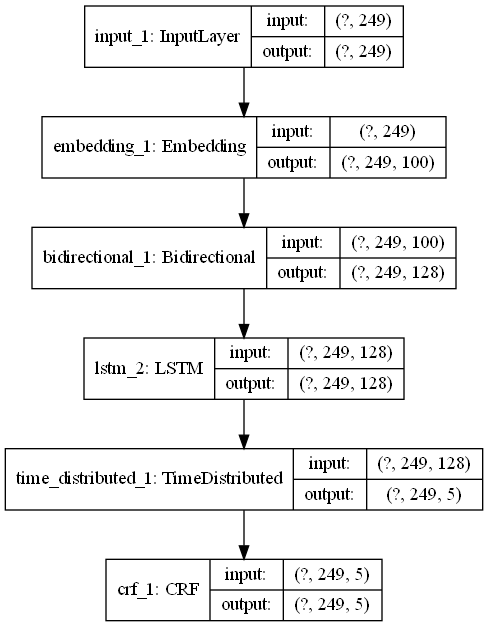

In [48]:
from tensorflow.keras.utils import plot_model

plot_model(model, "BiLSTM-CRF_model.png", show_shapes=True, show_layer_names=True)

## Save the model after each epoch if validation is better

In [49]:
# Saving the best only
filepath = "output test/ner-bi-lstm-td-model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max"
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor="val_acc",  # Bisa juga menggunakan 'val_loss'
    patience=5,  # Berhenti jika tidak ada peningkatan selama 5 epoch
    restore_best_weights=True,  # Mengembalikan bobot terbaik ketika berhenti
    verbose=1,
)

# # Gabungkan kedua callback
# callbacks_list = [checkpoint, early_stopping]

callbacks_list = [checkpoint]

## Fit

In [50]:
print(X_train.shape)

(862, 249)


In [51]:
history = model.fit(X_train, np.array(y_train), batch_size=20, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)




Train on 689 samples, validate on 173 samples
Epoch 1/20





689/689 [==============================] - 27s 39ms/step - loss: 1.9808 - crf_viterbi_accuracy: 0.0097 - acc: 0.0098 - val_loss: 1.9065 - val_crf_viterbi_accuracy: 0.0091 - val_acc: 0.0091

Epoch 00001: val_acc improved from -inf to 0.00915, saving model to output test/ner-bi-lstm-td-model-01-0.01.hdf5
Epoch 2/20
689/689 [==============================] - 29s 43ms/step - loss: 1.8548 - crf_viterbi_accuracy: 0.0098 - acc: 0.0098 - val_loss: 1.7953 - val_crf_viterbi_accuracy: 0.0091 - val_acc: 0.0091

Epoch 00002: val_acc did not improve from 0.00915
Epoch 3/20
689/689 [==============================] - 26s 38ms/step - loss: 1.7372 - crf_viterbi_accuracy: 0.0088 - acc: 0.0098 - val_loss: 1.6704 - val_crf_viterbi_accuracy: 0.0071 - val_acc: 0.0071

Epoch 00003: val_acc did not improve from 0.00915
Epoch 4/20
689/689 [==============================] - 26s 37ms/step - loss: 1.6042 - crf_viterbi_accuracy: 0.0078 - acc: 0.0098 -

# Accuracy

## Single prediction and verbose results

In [64]:
i = 28
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:10}): {}".format("Word", "True", "Pred"))
for idx, (w, pred) in enumerate(zip(X_test[i], p[0])):
    #
    print("{:14}: ({:10}): {}".format(words[w], idx2tag[gt[idx]], tags[pred]))

[3 3 3 3 3 3 0 4 3 2 1 3 3 3 3 0 4 3 3 3 3 3 3 3 0 4 3 2 1 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Word          : (True      ): Pred
bertujuan     : (O         ): O
1             : (O         ): O
Mengetahui    : (O         ): O
bentuk        : (O         ): O
struktur      : (O         ): O
pasar         : (O         ): O
Eucheuma      : (B-RUMPUT LAUT): B-RUMPUT LAUT
cottonii      : (I-RUMPUT LAUT): I-RUMPUT LAUT
kering        : (O         ): O
kota          : (B-LOKASI  ): B-LOKASI
Tual          : (I-LOKASI  ): I-LOKASI
2             : (O         ): O
Mengetahui    : (O         ): O

## Random Predict

In [65]:


def preprocess_input_text(input_text, word2idx, maxlen):
    # Split the input text into words (assumes space-separated words)
    words = input_text.split()

    # Convert words to their corresponding indices
    X_input = [word2idx.get(w, word2idx["ENDPAD"]) for w in words]  # Use ENDPAD for unknown words

    # Pad the sequence to the required maxlen
    X_input_padded = pad_sequences([X_input], maxlen=maxlen, padding="post", value=word2idx["ENDPAD"])

    return X_input_padded, words


In [66]:
def predict_entities(input_text, model, word2idx, idx2tag, maxlen):
    # Preprocess the input text
    X_input_padded, words = preprocess_input_text(input_text, word2idx, maxlen)
    
    # Predict using the model
    pred = model.predict(X_input_padded)
    
    # Get the predicted tags (indices) and convert them to actual tags
    pred_tags = [idx2tag[np.argmax(tag)] for tag in pred[0]]
    
    return list(zip(words, pred_tags))


In [67]:
# Input text
input_text = "Tujuan penelitian ini adalah untuk mengetahui perbedaan pertumbuhan rumput laut Kappaphycus alvarezi bibit lokal dan bibit hasil kultur jaringan. Penelitian dilakukan di perairan Seriweh Jerowaru Kabupaten Lombok Timur West Nusa Tenggara. Metode penelitian yang digunakan adalah metode eksperimental di perairan laut Seriweh. Budidaya rumput laut dilakukan dengan menggunakan metode longline. Budidaya dan pemeliharaan dilakukan selama 45 hari. Parameter yang digunakan adalah laju pertumbuhan mutlak dan kadar karaginan. Data dianalisa menggunakan statistik dan Uji-T. Hasil penelitian menunjukan bahwa pertumbuhan mutlak tertinggi sebesar 451,429 gram pada rumput laut hasil kultur jaringan dengan kadar karaginan sebesar 14,44 gram. Lokasi penanaman Semirang memiliki pergerakan air yang lebih kontinyu dengan kisaran nilai parameter kualitas air sesuai dengan kisaran kriteria habitat yang dikehendaki rumput laut. Kesimpulan penelitian ini adalah pertumbuhan rumput laut tertinggi dan kadar karaginan tertinggi diperolah pada rumput laut hasil kultur jaringan."
# input_text = "Tujuan penelitian ini adalah untuk mengetahui perbedaan pertumbuhan rumput laut Kappaphycus alvarezi dan Cottonii."
# input_text = "rumput laut Kappaphycus alvarezi di Kota Tarakan."

maxlen = 249
# Predict the entities in the input text
predicted_entities = predict_entities(input_text, model, word2idx, idx2tag, maxlen)

# Print the results
for word, tag in predicted_entities:
    print(f"{word}: {tag}")

Tujuan: O
penelitian: O
ini: O
adalah: O
untuk: O
mengetahui: O
perbedaan: O
pertumbuhan: O
rumput: O
laut: O
Kappaphycus: B-RUMPUT LAUT
alvarezi: I-RUMPUT LAUT
bibit: O
lokal: O
dan: O
bibit: O
hasil: O
kultur: O
jaringan.: O
Penelitian: O
dilakukan: O
di: O
perairan: O
Seriweh: B-RUMPUT LAUT
Jerowaru: I-RUMPUT LAUT
Kabupaten: B-LOKASI
Lombok: I-LOKASI
Timur: I-LOKASI
West: I-LOKASI
Nusa: I-LOKASI
Tenggara.: O
Metode: O
penelitian: O
yang: O
digunakan: O
adalah: O
metode: O
eksperimental: O
di: O
perairan: O
laut: O
Seriweh.: O
Budidaya: O
rumput: O
laut: O
dilakukan: O
dengan: O
menggunakan: O
metode: O
longline.: O
Budidaya: O
dan: O
pemeliharaan: O
dilakukan: O
selama: O
45: O
hari.: O
Parameter: O
yang: O
digunakan: O
adalah: O
laju: O
pertumbuhan: O
mutlak: O
dan: O
kadar: O
karaginan.: O
Data: O
dianalisa: O
menggunakan: O
statistik: O
dan: O
Uji-T.: O
Hasil: O
penelitian: O
menunjukan: O
bahwa: O
pertumbuhan: O
mutlak: O
tertinggi: O
sebesar: O
451,429: O
gram: O
pada: O
rumput

## Predict everything at once

In [68]:
p = model.predict(np.array(X_test))  

In [69]:
p.shape

(216, 249, 5)

In [70]:
p[1]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

## Nervaluate

In [71]:
def convert_to_spans(labels, idx2tag):
    spans = []
    start = None
    current_label = None

    for i, label in enumerate(labels):
        tag = idx2tag[label]

        if tag.startswith("B-"):
            if current_label is not None:
                spans.append({"label": current_label, "start": start, "end": i})
            start = i
            current_label = tag[2:]
        elif tag.startswith("I-") and current_label == tag[2:]:
            continue
        else:
            if current_label is not None:
                spans.append({"label": current_label, "start": start, "end": i})
            current_label = None

    if current_label is not None:
        spans.append({"label": current_label, "start": start, "end": len(labels)})

    return spans

In [72]:
import numpy as np


def get_spans_from_y(y, idx2tag):
    spans_list = []
    for label_sequence in y:
        spans_list.append(convert_to_spans(label_sequence, idx2tag))
    return spans_list


# Mengonversi y_true dan y_pred ke format span
y_true_spans = get_spans_from_y(np.argmax(y_test, axis=2), idx2tag)
y_pred_spans = get_spans_from_y(np.argmax(p, axis=2), idx2tag)

In [73]:
y_true_spans[1]

[{'label': 'RUMPUT LAUT', 'start': 6, 'end': 8},
 {'label': 'LOKASI', 'start': 23, 'end': 25},
 {'label': 'LOKASI', 'start': 25, 'end': 27},
 {'label': 'LOKASI', 'start': 27, 'end': 29},
 {'label': 'LOKASI', 'start': 29, 'end': 31},
 {'label': 'LOKASI', 'start': 37, 'end': 39},
 {'label': 'RUMPUT LAUT', 'start': 81, 'end': 83}]

In [74]:
y_pred_spans[1]

[{'label': 'RUMPUT LAUT', 'start': 6, 'end': 8},
 {'label': 'LOKASI', 'start': 23, 'end': 24},
 {'label': 'LOKASI', 'start': 24, 'end': 25},
 {'label': 'LOKASI', 'start': 25, 'end': 27},
 {'label': 'LOKASI', 'start': 27, 'end': 29},
 {'label': 'LOKASI', 'start': 37, 'end': 39},
 {'label': 'RUMPUT LAUT', 'start': 81, 'end': 83}]

In [75]:
len(y_true_spans)

216

In [76]:
len(y_pred_spans)

216

In [77]:
!pip install nervaluate

In [78]:
from nervaluate import Evaluator

evaluator = Evaluator(
    y_true_spans,
    y_pred_spans,
    tags=["LOKASI", "RUMPUT LAUT"],
)

results = evaluator.evaluate()

results

({'ent_type': {'correct': 995,
   'incorrect': 11,
   'partial': 0,
   'missed': 94,
   'spurious': 142,
   'possible': 1100,
   'actual': 1148,
   'precision': 0.8667247386759582,
   'recall': 0.9045454545454545,
   'f1': 0.8852313167259787},
  'partial': {'correct': 853,
   'incorrect': 0,
   'partial': 153,
   'missed': 94,
   'spurious': 142,
   'possible': 1100,
   'actual': 1148,
   'precision': 0.8096689895470384,
   'recall': 0.845,
   'f1': 0.8269572953736656},
  'strict': {'correct': 849,
   'incorrect': 157,
   'partial': 0,
   'missed': 94,
   'spurious': 142,
   'possible': 1100,
   'actual': 1148,
   'precision': 0.7395470383275261,
   'recall': 0.7718181818181818,
   'f1': 0.755338078291815},
  'exact': {'correct': 853,
   'incorrect': 153,
   'partial': 0,
   'missed': 94,
   'spurious': 142,
   'possible': 1100,
   'actual': 1148,
   'precision': 0.7430313588850174,
   'recall': 0.7754545454545455,
   'f1': 0.7588967971530249}},
 {'LOKASI': {'ent_type': {'correct': 513

## Sklearn Classification Report

In [79]:
from sklearn.metrics import classification_report

In [80]:
np.argmax(p, axis=2)[0]

array([3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [81]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

               precision    recall  f1-score   support

B-RUMPUT LAUT       0.84      0.93      0.89       507
     I-LOKASI       0.86      0.87      0.87       607
     B-LOKASI       0.80      0.85      0.83       552
            O       1.00      1.00      1.00     51777
I-RUMPUT LAUT       0.90      0.93      0.91       341

     accuracy                           0.99     53784
    macro avg       0.88      0.92      0.90     53784
 weighted avg       0.99      0.99      0.99     53784



### by LOKASI n RUMPUT LAUT

In [82]:
from sklearn.metrics import classification_report
import numpy as np


# Fungsi untuk menghapus prefix 'B-' atau 'I-' dari label
def remove_prefix(labels, idx2tag):
    return [
        idx2tag[idx].split("-")[-1] if "-" in idx2tag[idx] else idx2tag[idx]
        for idx in labels
    ]


# Mendapatkan label prediksi dan ground truth dalam bentuk ravel (flatten)
y_true = np.argmax(y_test, axis=2).ravel()
y_pred = np.argmax(p, axis=2).ravel()

# Transformasi label untuk menghilangkan prefix 'B-' atau 'I-'
y_true_transformed = remove_prefix(y_true, idx2tag)
y_pred_transformed = remove_prefix(y_pred, idx2tag)

# Hitung classification report setelah transformasi
print(
    classification_report(
        y_true_transformed,
        y_pred_transformed,
        target_names=list(set(y_true_transformed)),
    )
)

              precision    recall  f1-score   support

      LOKASI       0.87      0.91      0.89      1159
           O       1.00      1.00      1.00     51777
 RUMPUT LAUT       0.89      0.95      0.92       848

    accuracy                           0.99     53784
   macro avg       0.92      0.95      0.93     53784
weighted avg       0.99      0.99      0.99     53784



In [83]:
y_test[2]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [84]:
X_test[2]

array([14447, 11928,  4303, 12732,  5048, 11629,  9446,  2438,  7387,
       12060,   790,  4515,  4286,  9309,  7370, 14195,  4273,   614,
         902,  2409,  5944, 12677,  5187, 12550, 10620,  7210,  6225,
         307, 11160,  8516, 12207,  5481,  4286,  2504, 10395,  5563,
        9256, 12677, 15627,  5742, 11667, 10905,  7773,  9256, 14726,
        6319,  6512,  2147, 12275, 13321,  2980,  5989, 12732,  3837,
       11569, 14566,  2877,  8994, 12697, 11713, 11431,  5885,  5742,
       12280,  5313,  8883,  5313,  3731,  5313,  6693, 12135,  6797,
       11955,  2246,  7981, 16311, 13300, 12135,  6579,  9226,   112,
        4243, 15441, 13231,  8435, 12240,  7680,  7393, 11621,  6578,
        4567,  7393, 13089,  5313,   867, 13559,  5483, 15072,  8369,
       15925,  2980,  7755,  8967, 13747,   531, 11713, 11667,  5696,
       11920, 14491,  5989, 12732, 16512, 16512, 16512, 16512, 16512,
       16512, 16512, 16512, 16512, 16512, 16512, 16512, 16512, 16512,
       16512, 16512,

## Confussion Matrix

In [85]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

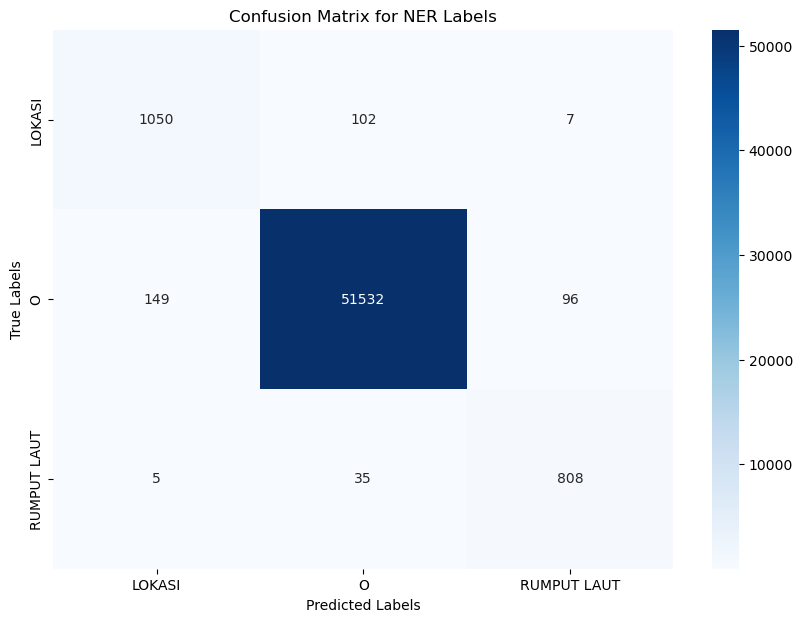

In [86]:
# Fungsi untuk menghapus prefix 'B-' atau 'I-' dari label
def remove_prefix(labels, idx2tag):
    return [
        idx2tag[idx].split("-")[-1] if "-" in idx2tag[idx] else idx2tag[idx]
        for idx in labels
    ]


# Mendapatkan label prediksi dan ground truth dalam bentuk ravel (flatten)
y_true = np.argmax(y_test, axis=2).ravel()
y_pred = np.argmax(p, axis=2).ravel()

# Transformasi label untuk menghilangkan prefix 'B-' atau 'I-'
y_true_transformed = remove_prefix(y_true, idx2tag)
y_pred_transformed = remove_prefix(y_pred, idx2tag)

# Buat confusion matrix
labels = list(set(y_true_transformed))  # Dapatkan label unik
cm = confusion_matrix(y_true_transformed, y_pred_transformed, labels=labels)

# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for NER Labels")
plt.show()

In [87]:
print(cm)

[[ 1050   102     7]
 [  149 51532    96]
 [    5    35   808]]


## Seqeval

In [88]:
!pip install seqeval

In [89]:
from seqeval.metrics import classification_report, accuracy_score


# Fungsi untuk menghapus prefix 'B-' atau 'I-' dari label
def remove_prefix(labels, idx2tag):
    return [
        idx2tag[idx].split("-")[-1] if "-" in idx2tag[idx] else idx2tag[idx]
        for idx in labels
    ]


# Mendapatkan label prediksi dan ground truth dalam bentuk ravel (flatten)
y_true = np.argmax(y_test, axis=2)
y_pred = np.argmax(p, axis=2)

# Mengubah format dari indeks ke label string
y_true_labels = [[idx2tag[idx] for idx in seq] for seq in y_true]
y_pred_labels = [[idx2tag[idx] for idx in seq] for seq in y_pred]

# Evaluasi menggunakan seqeval
print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

Accuracy: 0.9913914918935
Classification Report:
              precision    recall  f1-score   support

      LOKASI       0.68      0.74      0.71       552
 RUMPUT LAUT       0.79      0.87      0.83       507

   micro avg       0.73      0.81      0.77      1059
   macro avg       0.73      0.81      0.77      1059
weighted avg       0.73      0.81      0.77      1059



In [77]:
# from keras_contrib.utils import save_load_utils

# save_load_utils.save_all_weights(model, "bi_lstm_crf_ner_weights.h5")
# # save_load_utils.load_all_weights(model, "bi_lstm_crf_ner_weights.h5")

In [78]:
# model.save("bi_lstm_crf_ner_model.keras")

In [79]:
# import json

# # Simpan ke file JSON
# with open("pred_entities.json", "w") as file:
#     json.dump(pred_entities, file, indent=4)

# Thank You 🙏

In [80]:
# # Save model
# model.save("model_bilstm_crf.h5")

In [81]:
# import pickle

# # Menyimpan model sebagai pickle
# with open("bilstm_crf_model.pkl", "wb") as f:
#     pickle.dump(model, f)

# print("Model telah disimpan sebagai pickle file.")